In [ ]:
# Importations
!pip install keras-tuner
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold

import seaborn as sns
from typing import Tuple


In [2]:
# Fonction d'affichage des graphes de loss/accuracy

def accuracy_loss_graphe(historique):
    # Affichage accuracy - loss
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
    axs = axs.flatten()
    axs[0].plot(historique.history["accuracy"], label='Accuracy Train')
    axs[0].plot(historique.history["val_accuracy"], label='Accuracy Val')
    axs[0].set_title(f"Evolution de l'accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    axs[1].plot(historique.history["loss"], label='Loss Train')
    axs[1].plot(historique.history["val_loss"], label='Loss Val')
    axs[1].set_title(f"Evolution de la perte")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    plt.show()

In [3]:
# Fonction de création d'une image 'imparfaite' via une ancienne image - style 2

def create_imperfect_image(image: np.ndarray, image_size=(56, 56), seed=42)  -> np.ndarray:
    random.seed(seed)
    new_image = np.ones((*image_size, image.shape[2]), dtype=np.uint8)

    max_offset = image_size[0] - image.shape[0]
    random_x = random.randint(0, max_offset)
    random_y = random.randint(0, max_offset)

    new_image[random_x:random_x+image.shape[0], random_y:random_y+image.shape[1], :] = image
    return new_image

Le but est d'améliorer la robustesse du modèle de reconnaissance de chiffres manuscrits face aux variations de position, d'orientation et de taille des chiffres.

Créons donc un dataset augmenté contenant des variations réalistes de chiffres manuscrits pour entraîner un modèle plus performant et généralisable.

L'augmentation des données avec des transformations réalistes permettra d'améliorer la performance du modèle.

Méthodes:
- generation_propre: Génère de nouvelles images en appliquant des transformations géométriques aléatoires comme la rotation, le décalage, le zoom. (aussi nommé style 1)
- generation_imparfaite: Simule des imperfections en plaçant les chiffres à des positions aléatoires sur un fond plus grand. Cela vise à rendre le modèle plus robuste aux variations de position et de taille. (aussi nommé style 2)

Ces deux méthodes d'augmentation visent à couvrir un large spectre de variations réalistes que le modèle pourrait rencontrer en pratique.

In [4]:
# Fonction de création de nouvelles images via d'anciennes - style 1
def generation_propre(images: np.ndarray, labels: np.ndarray, nb=10000, seed=42) -> Tuple[np.ndarray, np.ndarray]:
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=(1.1, 1.9),
    )

    new_images_generator = datagen.flow(images, batch_size=1, shuffle=False, seed=seed)

    X_new = images.tolist()
    y_new = labels.tolist()
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
    axs = axs.flatten()
    current_seed = seed
    for i in range(nb):

        new_images_generator = datagen.flow(images[i:i+1], batch_size=1, shuffle=False, seed=current_seed)
        img = next(new_images_generator)[0]
        X_new.append(img.tolist())
        y_new.append(labels[i].tolist())
        current_seed += 1
        if i < 6:
          axs[i].imshow(img, cmap="grey")
          axs[i].axis("off")
    plt.show()
    return np.array(X_new), np.array(y_new)


Fonction de création de nb images modifiées par create_imperfect_image sur les images (style 2)

In [5]:
# Fonction de création de nouvelles images via d'anciennes - style 2

def generation_imparfaite(images: np.ndarray, labels: np.ndarray, nb=10000, seed=42) -> Tuple[np.ndarray, np.ndarray]:
    new_images = images.tolist()
    new_images_label = labels.tolist()

    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
    axs = axs.flatten()

    for i in range(nb):
        imperfect_image = create_imperfect_image(images[i], seed=i+seed)

        # imperfect_image = tf.image.resize(imperfect_image, (28, 28))
        imperfect_image = tf.expand_dims(imperfect_image, axis=0)
        imperfect_image = tf.nn.max_pool2d(imperfect_image, ksize=2, strides=2, padding="VALID")

        imperfect_image = imperfect_image.numpy().reshape(28, 28, 1)


        new_images.append(imperfect_image.tolist())
        new_images_label.append(labels[i].tolist())

        if i < 6:

          axs[i].imshow(imperfect_image, cmap="grey")
          axs[i].axis("off")

    plt.show()

    new_images = np.array(new_images)
    new_images_label = np.array(new_images_label)

    return new_images, new_images_label

Le jeu de données MNIST est chargé. Il contient 60 000 images pour l'entraînement et 10 000 pour les tests.

Les images sont normalisées en ajustant les valeurs de pixels entre 0 et 1.

Les couleurs sont inversées pour avoir des chiffres noirs sur fond blanc.

120 000 nouvelles images sont créées pour l'entraînement :
- _generation_propre_ : Rotation, décalage et zoom aléatoires des chiffres.
- _generation_imparfaite_ : Placement des chiffres à des positions aléatoires sur un fond plus grand.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


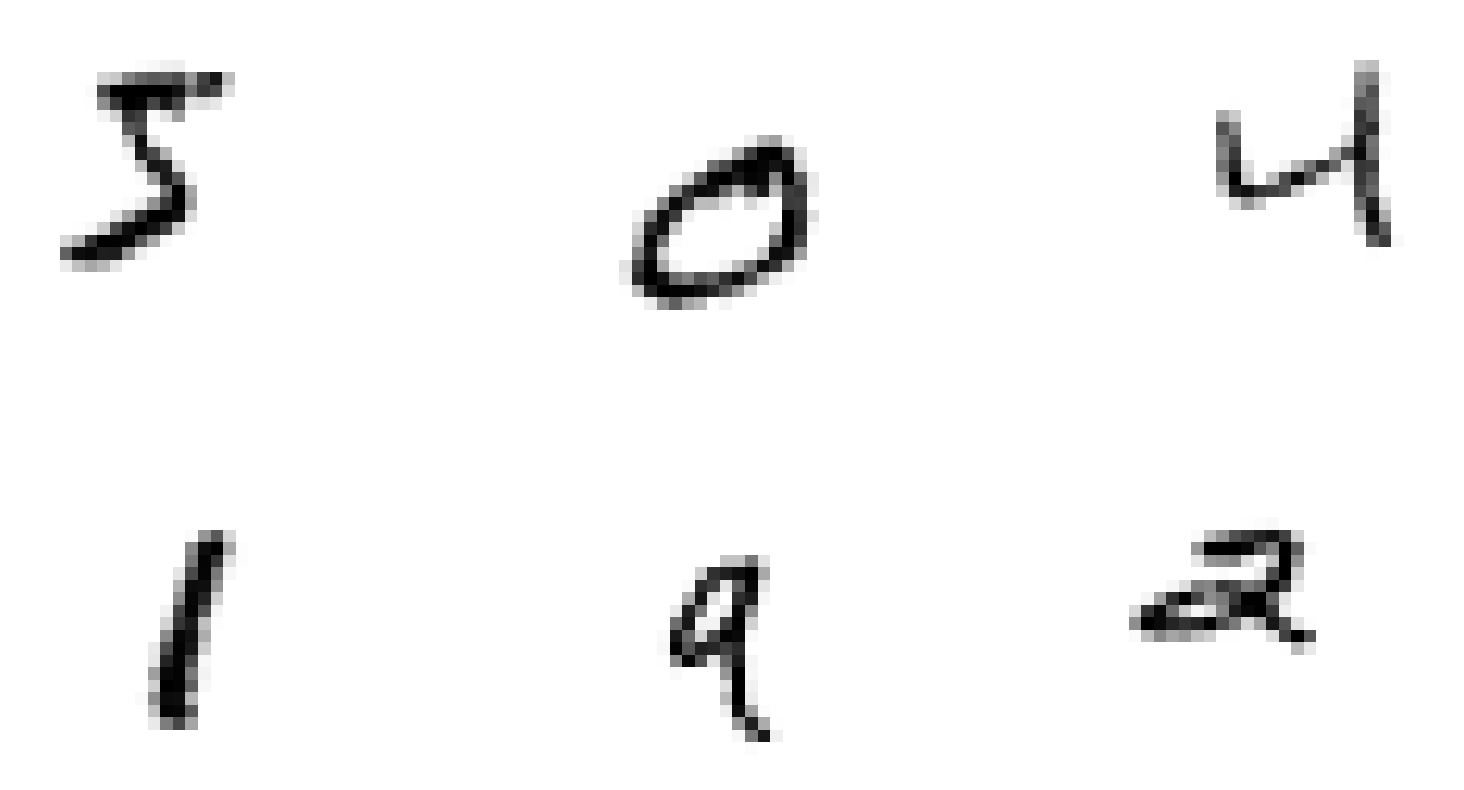

In [6]:
# Chargement et traitement des données MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalisation
x_train = x_train / 255.0
x_test = x_test / 255.0

# Inversion
x_train = 1 - x_train
x_test = 1 - x_test

# Génération de nouvelles données imparfaites
x_train, y_train = generation_propre(x_train, y_train, 60000) #  style 1

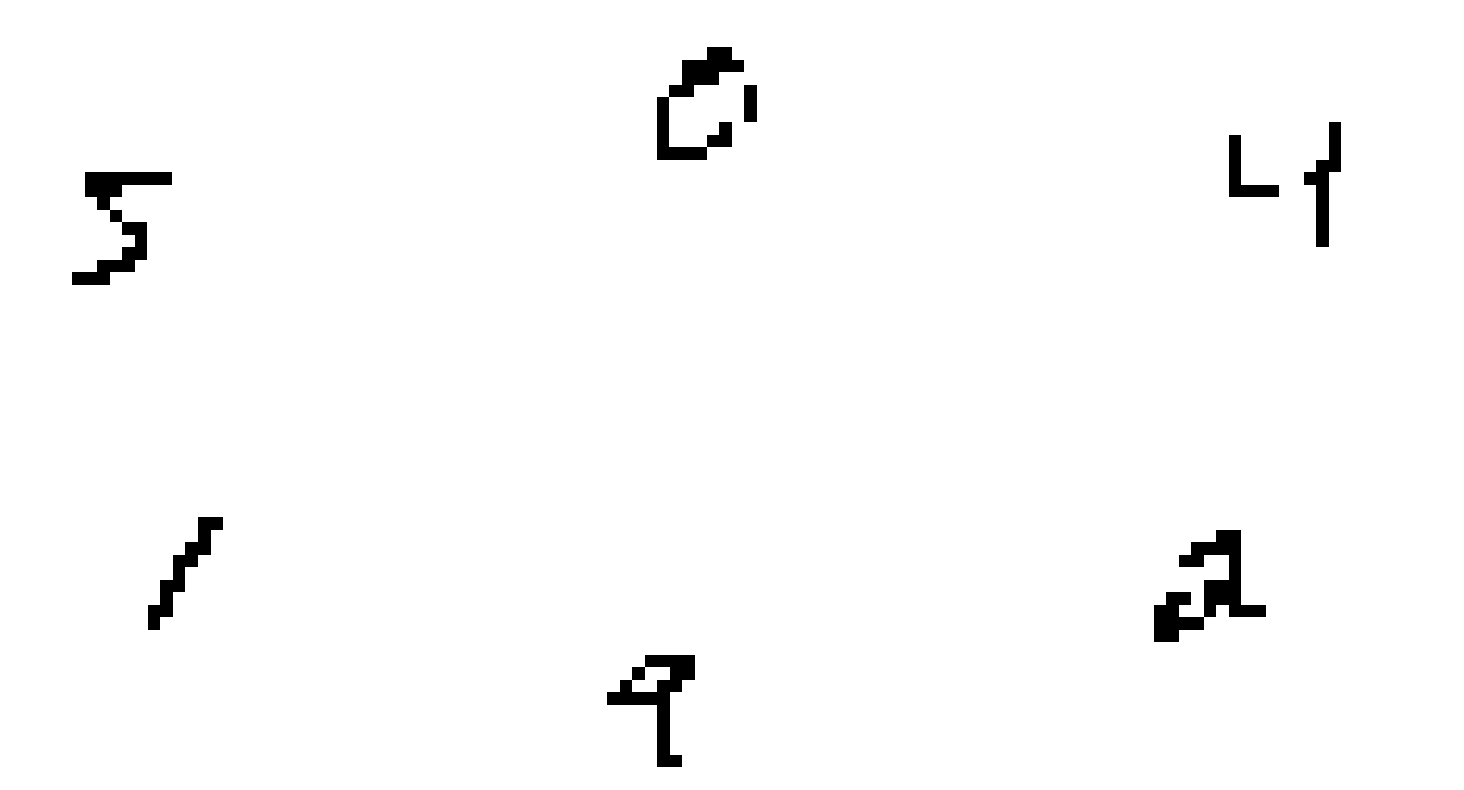

In [7]:
# Génération de nouvelles données imparfaites
x_train, y_train = generation_imparfaite(x_train, y_train, 60000) #  style 2

- Affichage des 6 premiers éléments du jeu d'entrainement de base

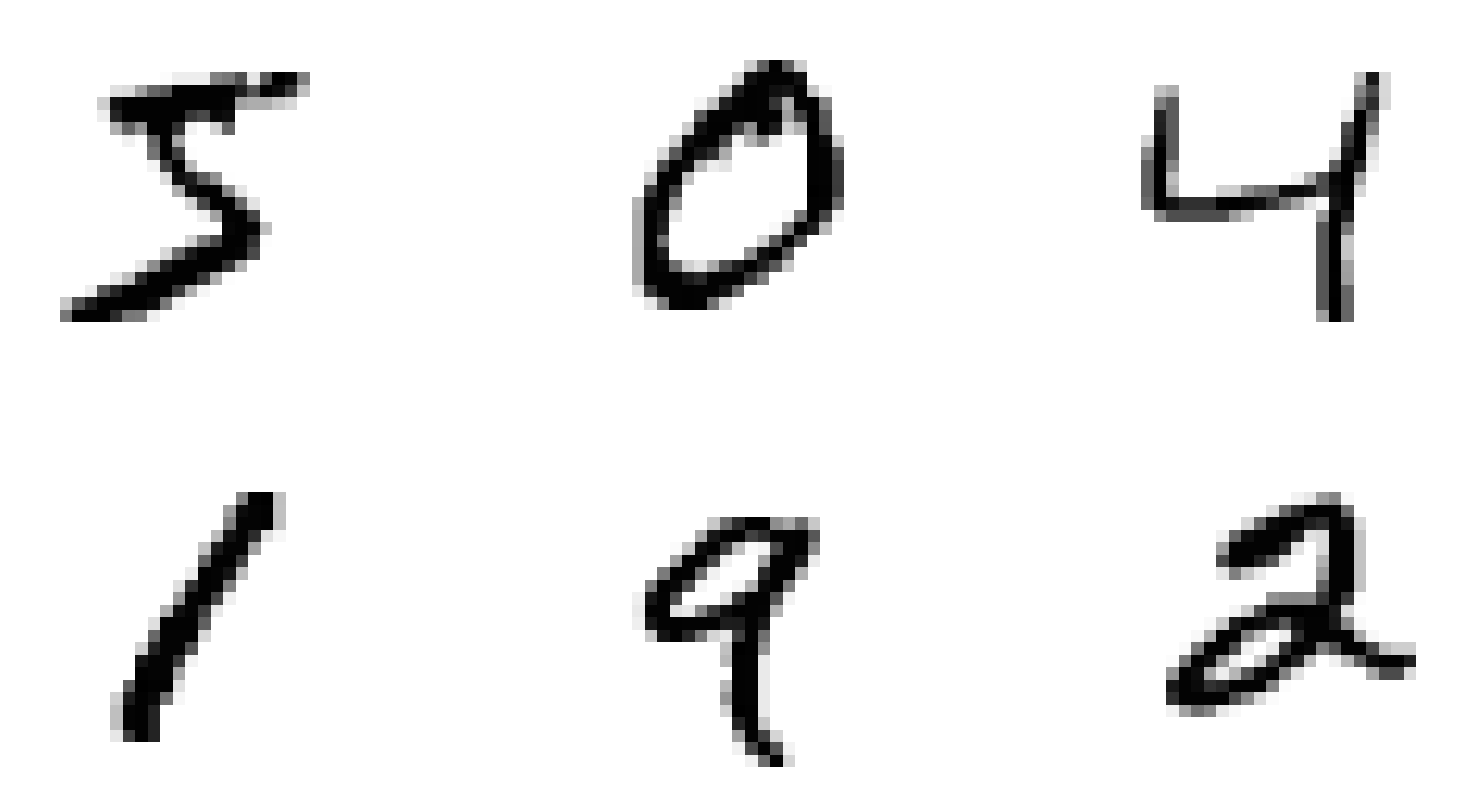

In [8]:
# Apercu dataset de base
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
axs = axs.flatten()
for i in range(6):
    axs[i].imshow(x_train[i], cmap="grey")
    axs[i].axis("off")
plt.show()

- Mélange du jeu d'entrainement

In [9]:

# Mélange (pour validation_split)
np.random.seed(42)
indice = np.random.permutation(len(x_train))
x_train = x_train[indice]
y_train = y_train[indice]

**Modele finale**

Le modèle est un réseau neuronal convolutif (CNN) conçu pour la classification d'images. Il prend en entrée une image en niveaux de gris de taille 28x28 pixels, représentée par une matrice (28, 28, 1).

Le modèle utilise 3 couches de double convolution. Chaque couche de convolution applique un ensemble de filtres à l'image d'entrée pour extraire des caractéristiques. L'augmentation progressive du nombre de neurones dans les couches de convolution permet au modèle d'apprendre des caractéristiques de plus en plus complexes.
- La double convolution permet d'affiner la détection de caractéristiques.
- Max Pooling : Réduit la dimensionnalité des données en sélectionnant la valeur maximale dans une fenêtre donnée.

Batch Normalization: Normalise les activations des couches précédentes, ce qui accélère la convergence du modèle pendant l'entraînement.

Dropout: Désactive aléatoirement des neurones pendant l'entraînement, ce qui force le modèle à apprendre des représentations plus robustes et à éviter le surapprentissage.

Couches entièrement connectées: Deux couches entièrement connectées avec 512 neurones chacune. Ces couches combinent les caractéristiques extraites par les couches convolutives pour effectuer la classification finale.

Sortie softmax: La couche de sortie utilise une fonction softmax pour produire une distribution de probabilité sur les 10 classes possibles (chiffres de 0 à 9).

Optimisation : Le modèle est entraîné en utilisant l'optimiseur AdamW

In [23]:
# Définition du modele

def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.4),

      Flatten(),

      Dense(512, activation='relu'),
      Dropout(0.4),
      BatchNormalization(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      BatchNormalization(),

      Dense(10, activation="softmax")
  ])
  optimizer = AdamW(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model

**Callbacks : ReduceLROnPlateau**

Le callback ReduceLROnPlateau est utilisé pour réduire dynamiquement le taux d'apprentissage pendant l'entraînement lorsque la performance du modèle sur un ensemble de validation cesse de s'améliorer.

**Évaluation**

La performance du modèle est évaluée en utilisant l'accuracy et la perte. L'accuracy mesure la proportion de prédictions correctes, tandis que la perte quantifie l'erreur du modèle. L'évolution de ces métriques au cours de l'entraînement est affichée pour surveiller la convergence du modèle et détecter un éventuel surapprentissage.

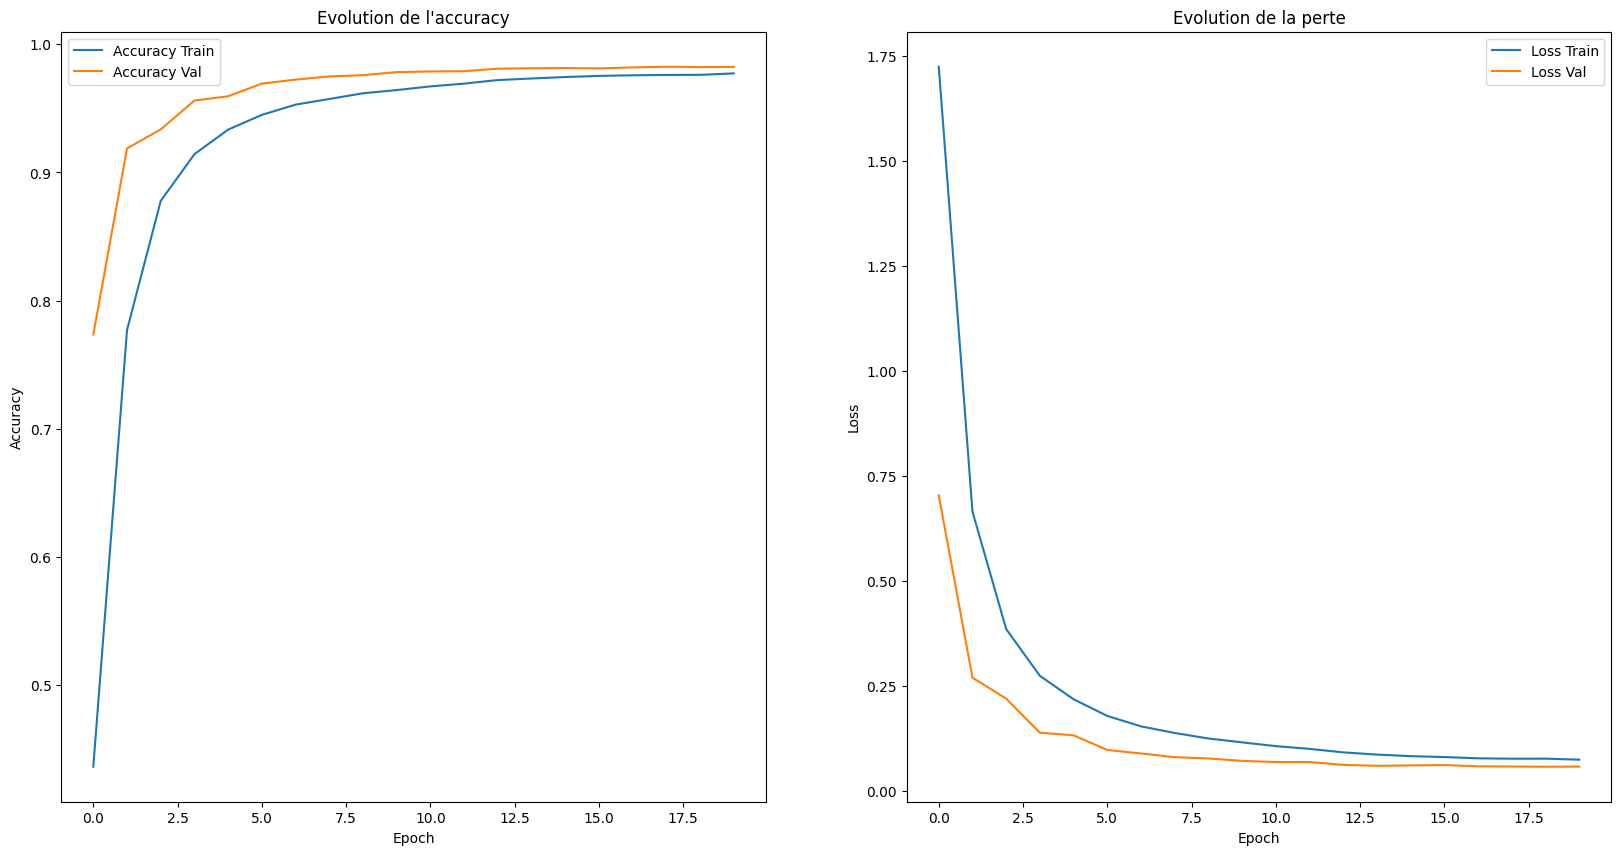

Accuracy :  0.977263867855072
Loss :  0.07390271127223969
Accuracy Validation :  0.9822777509689331
Loss Validation :  0.057419296354055405


In [24]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=0,
    min_lr=1e-6,
    verbose=1
)
model_20 = build_model()
historique = model_20.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=128, callbacks=[reduce_lr])
clear_output(wait=True)
accuracy_loss_graphe(historique)

print("Accuracy : ", historique.history["accuracy"][-1])
print("Loss : ", historique.history["loss"][-1])
print("Accuracy Validation : ", historique.history["val_accuracy"][-1])
print("Loss Validation : ", historique.history["val_loss"][-1])

# Impact de l'absence de Dropout

Les résultats montrent un overfitting clair : le modèle a sur-appris les données d'entraînement, obtenant une excellente performance sur celles-ci mais une faible performance sur le jeu de validation.

**Le rôle du Dropout**

Le Dropout est une technique de régularisation qui prévient l'overfitting en désactivant aléatoirement des neurones pendant l'entraînement. Cela force le modèle à apprendre des représentations plus robustes et moins dépendantes de neurones spécifiques.

**Observation**

Sans Dropout, le modèle s'est adapté excessivement aux particularités du jeu d'entraînement, mémorisant les exemples plutôt que d'apprendre des caractéristiques générales. L'écart important entre les performances d'entraînement et de validation confirme cet overfitting.

**Conclusion**

Le Dropout est donc essentiel pour la performance du modèle, améliorant sa robustesse et sa capacité à généraliser à de nouvelles données.



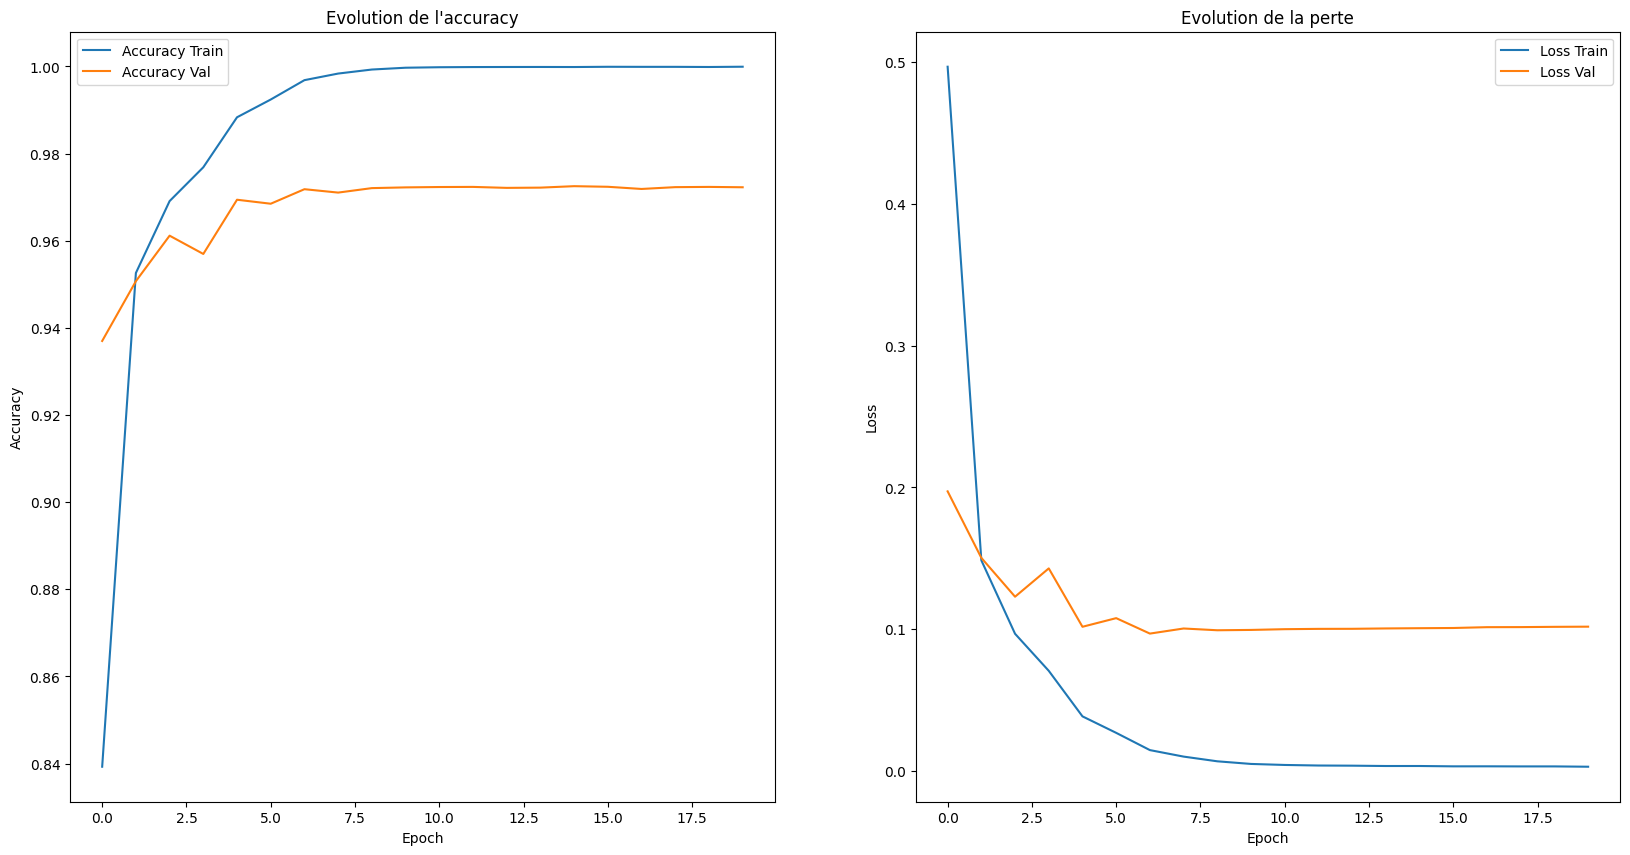

In [10]:
# Définition du modele

def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),

      Flatten(),

      Dense(512, activation='relu'),
      BatchNormalization(),
      Dense(512, activation='relu'),
      BatchNormalization(),

      Dense(10, activation="softmax")
  ])
  optimizer = AdamW(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model

# Affichage
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=0,
    min_lr=1e-6,
    verbose=1
)
model_20 = build_model()
historique = model_20.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=128, callbacks=[reduce_lr])
clear_output(wait=True)
accuracy_loss_graphe(historique)
model = model_20

# Impact de l'absence de Batch Normalization

Les résultats montrent que le modèle conserve une performance acceptable, mais on observe une convergence légèrement plus lente pendant l'entraînement.

**Le rôle de la Batch Normalization**

La Batch Normalization est une technique qui normalise les activations des couches précédentes, ce qui accélère la convergence du modèle pendant l'entraînement. Elle permet de stabiliser l'apprentissage en réduisant les variations des données d'entrée de chaque couche.

**Observation**

Sans Batch Normalization, le modèle a toujours appris à classifier les chiffres manuscrits, mais la convergence a été plus lente. Cela signifie qu'il a fallu plus d'epochs pour atteindre un niveau de performance comparable au modèle initial avec Batch Normalization.

**Conclusion**

Bien que la Batch Normalization ne soit pas essentielle à la performance globale du modèle dans ce cas, elle contribue à une convergence plus rapide et à un apprentissage plus stable.



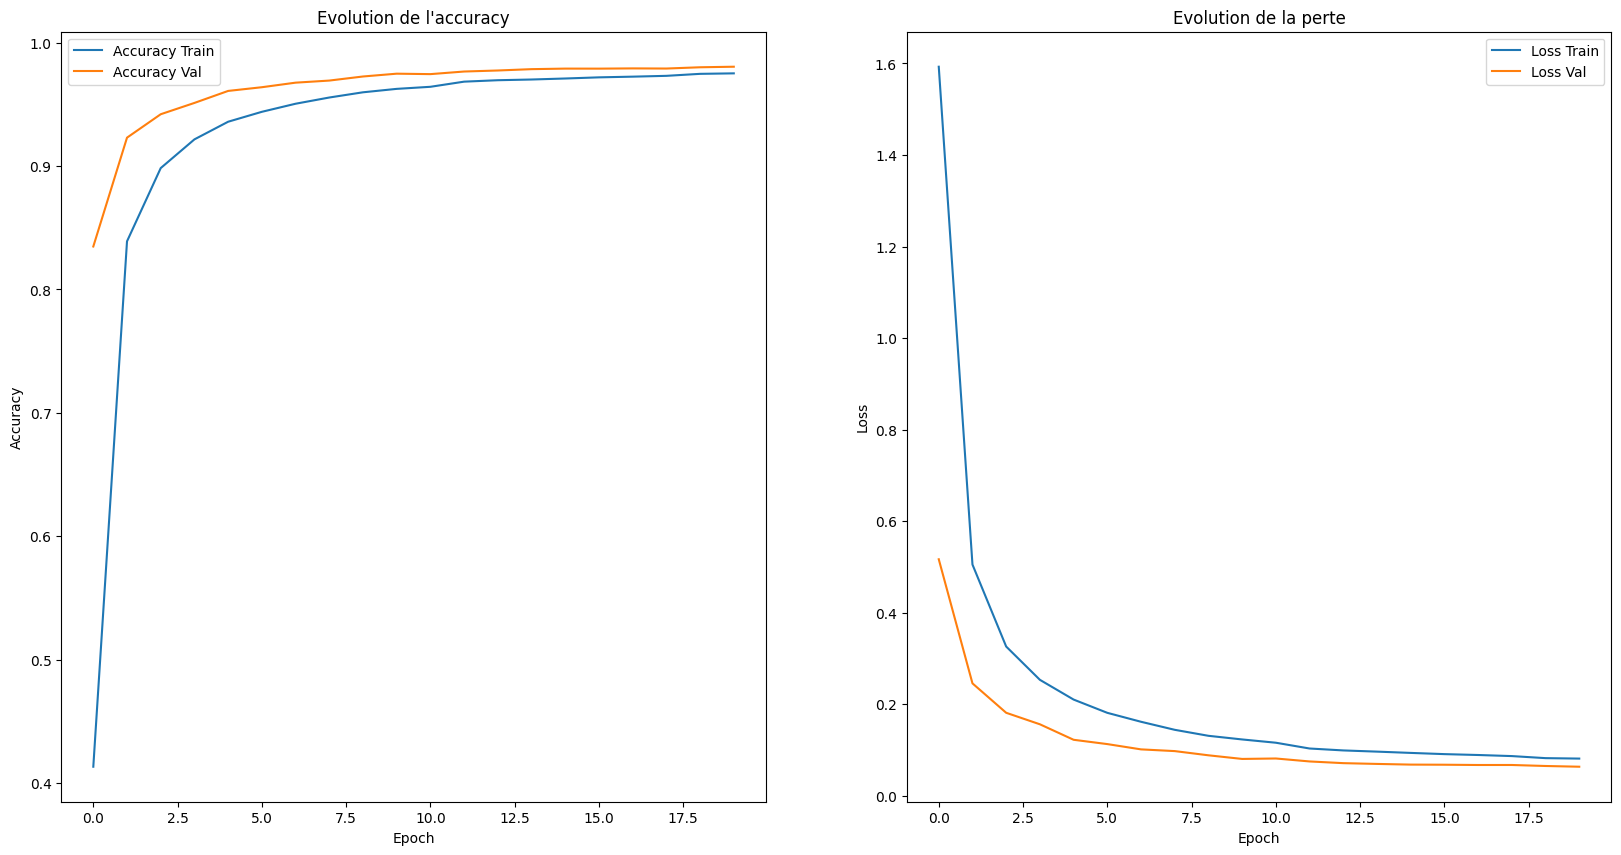

Accuracy :  0.9750972390174866
Loss :  0.08141624182462692
Accuracy Validation :  0.980472207069397
Loss Validation :  0.0636429712176323


In [20]:
# Définition du modele

def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      Conv2D(128, (3, 3), activation='relu', padding="same"),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.4),

      Flatten(),

      Dense(512, activation='relu'),
      Dropout(0.4),
      Dense(512, activation='relu'),
      Dropout(0.5),

      Dense(10, activation="softmax")
  ])
  optimizer = AdamW(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model

model_20 = build_model()
historique = model_20.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=128, callbacks=[reduce_lr])
clear_output(wait=True)
accuracy_loss_graphe(historique)
model = model_20

print("Accuracy : ", historique.history["accuracy"][-1])
print("Loss : ", historique.history["loss"][-1])
print("Accuracy Validation : ", historique.history["val_accuracy"][-1])
print("Loss Validation : ", historique.history["val_loss"][-1])

# Impact de l'utilisation de couches de convolution simples

L'expérimentation consiste à remplacer les doubles couches de convolution par des couches simples. Les résultats montrent un moins bon apprentissage sur les jeux d'entrainement et de validation, avec un écart entre les résultats des ces derniers.

**Le rôle des doubles couches de convolution**

L'utilisation de doubles couches de convolution permet d'affiner la détection de caractéristiques dans les images

**Observation et Interprétation**

Avec des couches simples, le modèle a eu plus de difficultés à apprendre des représentations efficaces des chiffres manuscrits. Cela se traduit par une moins bonne performance.

L'écart entre les résultats d'entraînement et de validation, avec une validation meilleure que l'entraînement, peut indiquer que le modèle avec couches simples est moins sujet à l'overfitting. Cela pourrait être dû au fait qu'il a une capacité d'apprentissage plus limitée, ce qui l'empêche de mémoriser excessivement les données d'entraînement.

**Conclusion**

En raison de ses meilleures performances, l'utilisation de doubles couches de convolution est préférable pour ce type de tâche de classification d'images.


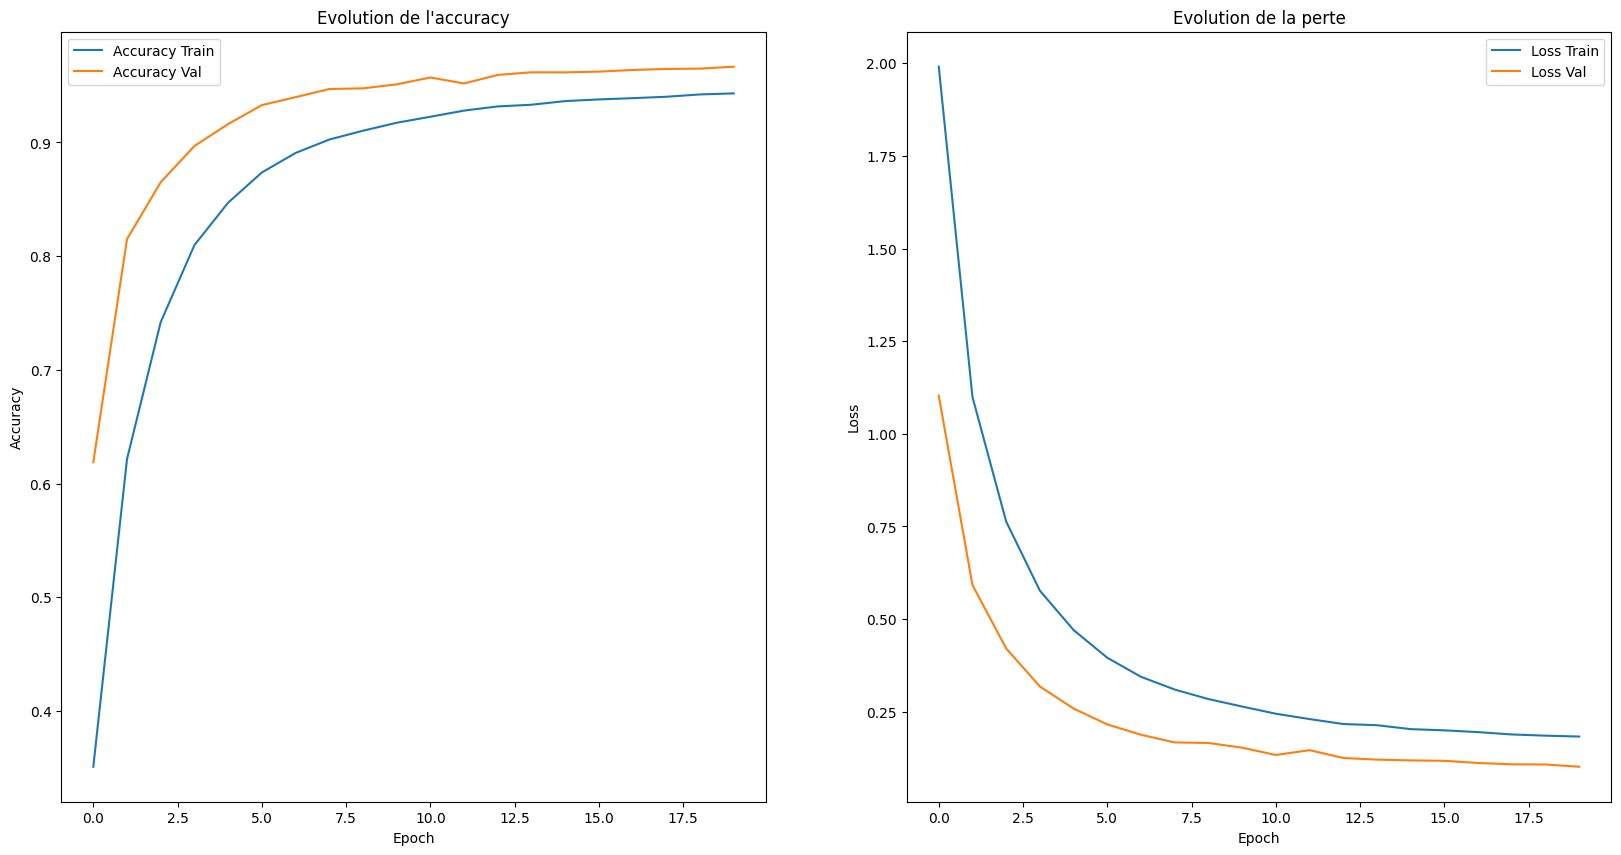

Accuracy :  0.9431735873222351
Loss :  0.18288543820381165
Accuracy Validation :  0.9666388630867004
Loss Validation :  0.10148567706346512


In [21]:
# Définition du modele

def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.4),

      Flatten(),

      Dense(512, activation='relu'),
      Dropout(0.4),
      BatchNormalization(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      BatchNormalization(),

      Dense(10, activation="softmax")
  ])
  optimizer = AdamW(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model

model_20 = build_model()
historique = model_20.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=128, callbacks=[reduce_lr])
clear_output(wait=True)
accuracy_loss_graphe(historique)
model = model_20

print("Accuracy : ", historique.history["accuracy"][-1])
print("Loss : ", historique.history["loss"][-1])
print("Accuracy Validation : ", historique.history["val_accuracy"][-1])
print("Loss Validation : ", historique.history["val_loss"][-1])

# Impact de l'utilisation de deux doubles couches de convolution au lieu de trois

L'expérimentation consiste à réduire le nombre de blocs de doubles couches de convolution (avec Max Pooling) de trois à deux. Les résultats montrent que le modèle avec deux blocs converge légèrement moins vite et obtient des performances légèrement inférieures à celui avec trois blocs.

**Le rôle des couches de convolution (et du Max Pooling)**

Comme dit plus tôt les couches de convolution extraient des caractéristiques des images, tandis que le Max Pooling réduit la dimensionnalité des données et la complexité du modèle. En augmentant le nombre de blocs de doubles couches de convolution et de Max Pooling, on augmente la capacité du modèle à apprendre des représentations complexes et nuancées des données.

**Observations**

- Convergence : La convergence légèrement plus lente du modèle avec deux blocs suggère qu'il a besoin de plus d'itérations pour apprendre des représentations efficaces des données.
- Performance : Les résultats légèrement meilleurs du modèle avec trois blocs, tant en termes d'accuracy que de loss, confirment que l'augmentation du nombre de couches permet d'améliorer la performance globale du modèle.

**Conclusion**

Bien que le modèle avec deux blocs de doubles couches de convolution reste performant, le modèle avec trois blocs offre une meilleure performance globale et une convergence plus rapide.



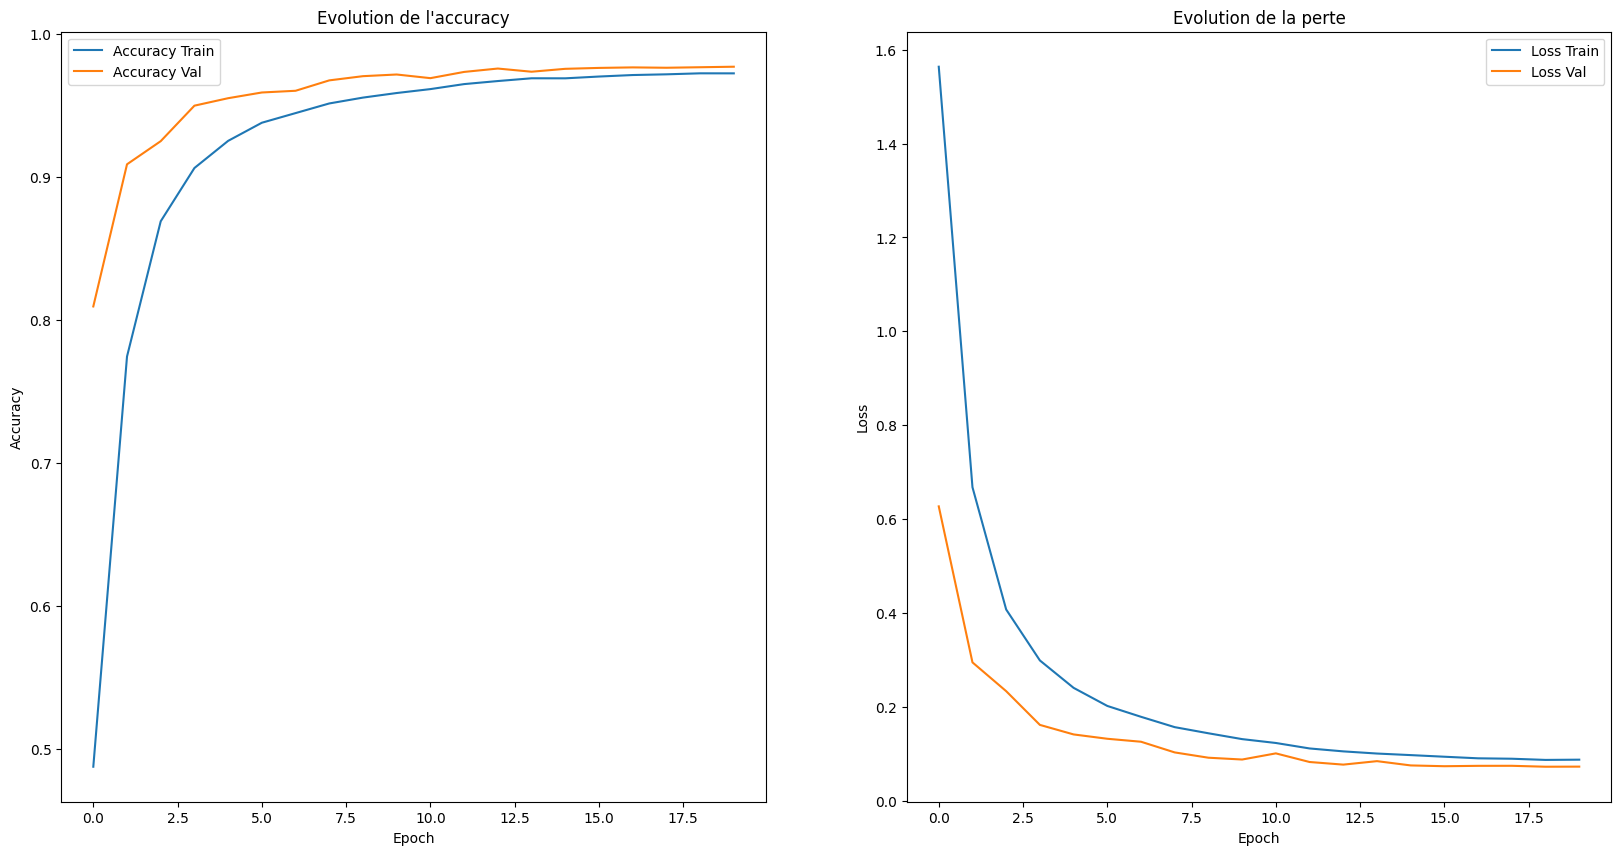

Accuracy :  0.972493052482605
Loss :  0.08765244483947754
Accuracy Validation :  0.977138876914978
Loss Validation :  0.07282291352748871


In [17]:
# Définition du modele

def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Flatten(),

      Dense(512, activation='relu'),
      Dropout(0.4),
      BatchNormalization(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      BatchNormalization(),

      Dense(10, activation="softmax")
  ])
  optimizer = AdamW(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model

model_20 = build_model()
historique = model_20.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=128, callbacks=[reduce_lr])
clear_output(wait=True)
accuracy_loss_graphe(historique)
model = model_20

print("Accuracy : ", historique.history["accuracy"][-1])
print("Loss : ", historique.history["loss"][-1])
print("Accuracy Validation : ", historique.history["val_accuracy"][-1])
print("Loss Validation : ", historique.history["val_loss"][-1])

# Impact de l'utilisation de l'optimiseur SGD

Les résultats montrent une performance significativement dégradée du modèle, avec une accuracy et une loss médiocres tant sur le jeu d'entraînement que sur le jeu de validation.

**Le rôle de l'optimiseur**

L'optimiseur est un algorithme qui ajuste les poids du modèle pendant l'entraînement afin de minimiser la fonction de perte. AdamW et SGD sont deux optimiseurs populaires, mais ils ont des caractéristiques différentes :

- AdamW est un optimiseur adaptatif qui ajuste le taux d'apprentissage pour chaque poids individuellement. Il est généralement plus rapide et plus performant que SGD, en particulier pour les modèles complexes.
- SGD est un optimiseur plus simple qui utilise un taux d'apprentissage fixe pour tous les poids.

**Conclusion**

L'expérimentation avec SGD a démontré son inadaptation à ce modèle de classification d'images, confirmant la pertinence du choix initial d'AdamW comme optimiseur. AdamW, étant un optimiseur performant et adaptatif, a permis d'obtenir d'excellents résultats en termes d'accuracy et de convergence.

Compte tenu de ces performances satisfaisantes avec AdamW, on ne va pas jugé nécessaire de mener des comparaisons exhaustives avec tous les autres optimiseurs disponibles, qui sont nombreux. L'effort d'optimisation se concentre davantage sur les aspects architecturaux du modèle et les techniques de régularisation, comme exploré dans ce notebook.

**Remarques**

Il est possible que d'autres optimiseurs puissent offrir des performances légèrement meilleures que AdamW dans certains cas spécifiques.
Cependant, AdamW est un choix solide et largement utilisé pour les modèles de deep learning, ce qui justifie sa sélection dans ce contexte.


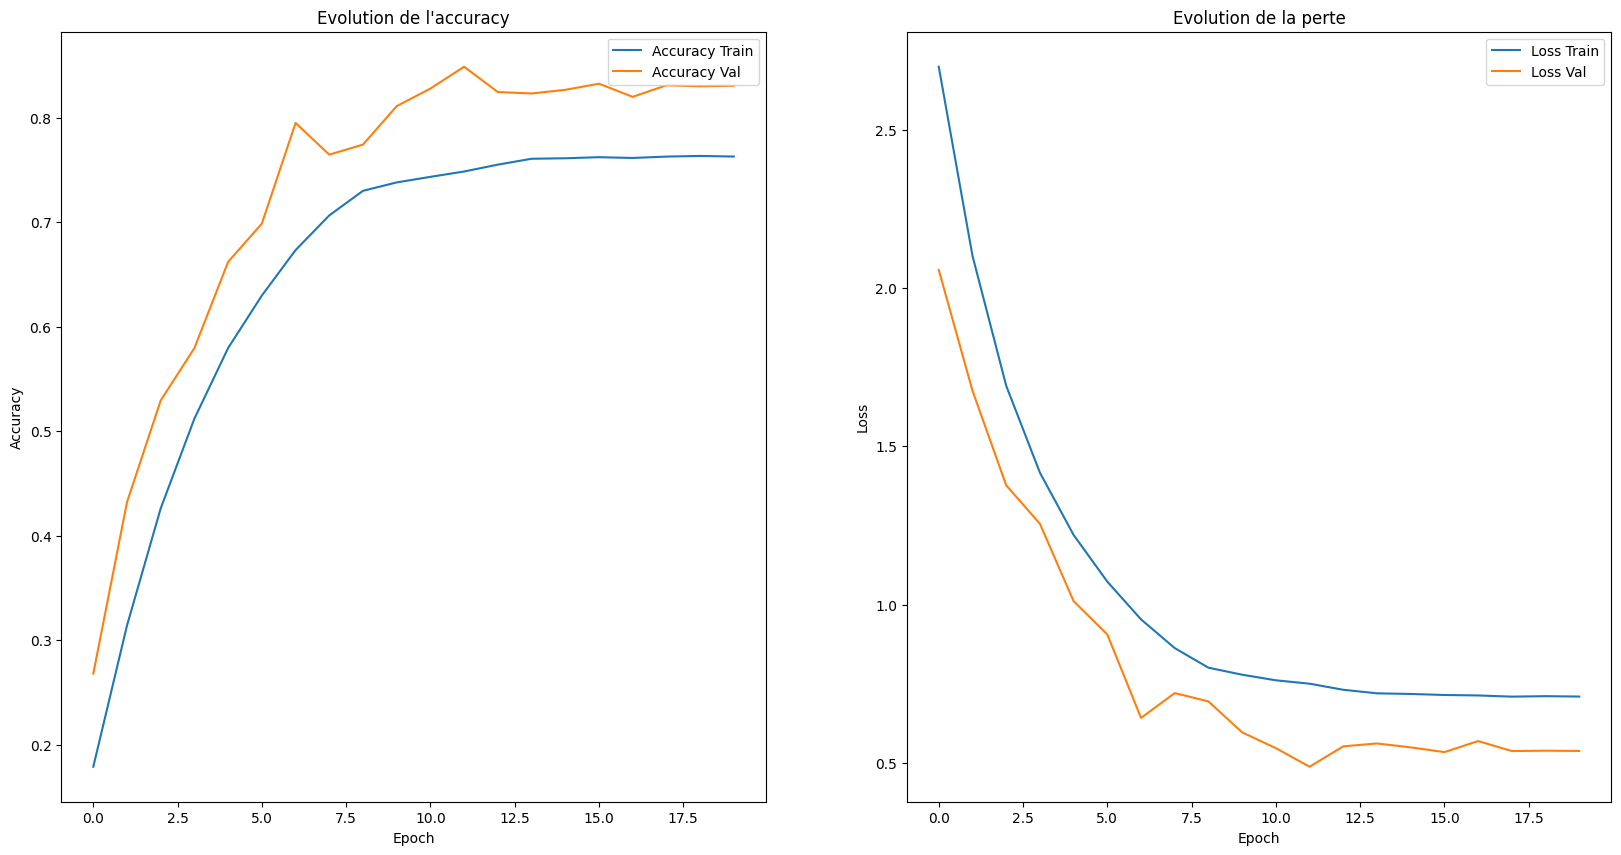

Accuracy :  0.7627360820770264
Loss :  0.7093061208724976
Accuracy Validation :  0.8304722309112549
Loss Validation :  0.5373286008834839


In [28]:
# Définition du modele

def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.4),

      Flatten(),

      Dense(512, activation='relu'),
      Dropout(0.4),
      BatchNormalization(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      BatchNormalization(),

      Dense(10, activation="softmax")
  ])
  optimizer = SGD(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model

model_20 = build_model()
historique = model_20.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=128, callbacks=[reduce_lr])
clear_output(wait=True)
accuracy_loss_graphe(historique)
model = model_20

print("Accuracy : ", historique.history["accuracy"][-1])
print("Loss : ", historique.history["loss"][-1])
print("Accuracy Validation : ", historique.history["val_accuracy"][-1])
print("Loss Validation : ", historique.history["val_loss"][-1])